# Logistic Classifier for Predicting Customer Churn in SyriaTel

# Overview
The telecommunications industry, specifically SyriaTel, faces challenges with customer retention leading to financial losses. This project aims to utilize data science techniques to build a predictive model that can identify potential churners - customers who are likely to discontinue their services with SyriaTel. By understanding patterns in customer behavior, this model intends to assist the telecom business in minimizing losses associated with customer attrition.

## Business Understanding
Telecom companies rely on retaining customers for sustainable growth. Understanding customer behavior and predicting churn can aid in developing strategies to retain existing customers. This initiative seeks to provide actionable insights to stakeholders, including SyriaTel and other telecom entities, to refine customer engagement strategies, reduce churn, and enhance customer loyalty.

## Problem Statement
The primary challenge is to develop a classification model that accurately predicts whether a customer is likely to churn or not. Predicting churn patterns will enable SyriaTel to take proactive measures, such as personalized retention strategies or targeted promotions, to mitigate customer attrition.

## Objectives
- **Predictive Model**: Develop a classifier that predicts churn with at least 85% accuracy, assisting SyriaTel in identifying customers at risk of leaving.
- **Identifying Key Features**: Determine the main factors influencing churn rate to guide targeted retention efforts. Two prominent features contributing to churn prediction will be identified.


In [1]:
# Data Manipulation and Analysis
import numpy as np
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Statistical Tests
from scipy.stats import chi2_contingency, pointbiserialr

# Preprocessing and Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline  # For creating data processing pipelines
from sklearn.preprocessing import (  # For data preprocessing
    StandardScaler,  # For scaling features
    PolynomialFeatures  # For generating polynomial features
)
from sklearn.decomposition import PCA  # For dimensionality reduction
from sklearn.impute import SimpleImputer, KNNImputer  # For handling missing values
from sklearn.model_selection import StratifiedKFold  # For cross-validation
from imblearn.over_sampling import SMOTE  # For handling class imbalance
import category_encoders as ce  # For categorical encoding
from sklearn.feature_selection import RFE  # For feature selection
from sklearn.pipeline import FeatureUnion  # For combining feature extraction methods

# Model Selection and Evaluation
from sklearn.model_selection import GridSearchCV  # For hyperparameter tuning
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score  # For model evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

# model Deployment
import joblib

    READING THE DATA INTO A DataFrame

In [2]:
df = pd.read_csv('data.csv')
df.head(3)

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False


### 1. DATA OVERVIEW

In [3]:
df.shape

(3333, 21)

In [4]:
df.columns

Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [6]:
# df.describe(include='all')

### 2. DATA CLEANING

#### 2.1 Duplicated Values

In [7]:
df.duplicated().any()

False

In [8]:
df.churn = df.churn.astype(int)
df.churn.value_counts()

churn
0    2850
1     483
Name: count, dtype: int64

    There are no duplicated values

#### 2.2 Missing Values

In [9]:
df.isnull().sum()

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

    There are no Missing values

In [10]:
def get_column_types(df):
    # Get categorical columns
    categorical_columns = df.select_dtypes(include='object').columns.tolist()

    # Get numeric columns
    numeric_columns = df.select_dtypes(include=['int', 'float']).columns.tolist()

    return categorical_columns, numeric_columns

In [11]:
categorical_columns, numeric_columns = get_column_types(df)

In [12]:
categorical_columns

['state', 'phone number', 'international plan', 'voice mail plan']

In [13]:
numeric_columns

['account length',
 'area code',
 'number vmail messages',
 'total day minutes',
 'total day calls',
 'total day charge',
 'total eve minutes',
 'total eve calls',
 'total eve charge',
 'total night minutes',
 'total night calls',
 'total night charge',
 'total intl minutes',
 'total intl calls',
 'total intl charge',
 'customer service calls',
 'churn']

In [14]:
def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = df[col].map({'yes': 1, 'no': 0})


In [15]:
convert_to_numeric(df, ['international plan', 'voice mail plan' ])

### 3. FEATURE ENGINEERING (part 1)

#### 3.1 Extracting Area Code from Phone Number

In [16]:

df['phone area code'] = df['phone number'].apply(lambda x: x.split('-')[0])
# Ensure 'area_code' column is numeric
df['phone area code'] = pd.to_numeric(df['phone area code'], errors='coerce') 


     Cleaning and setting phone number as Index

In [17]:
# Removing hyphen and converting to numeric
df['phone number'] = df['phone number'].str.replace('-', '').astype(int)
# Setting the phone number as the index
df.set_index('phone number', inplace=True)


In [18]:
categorical_columns

['state', 'phone number', 'international plan', 'voice mail plan']

In [19]:
numeric_columns

['account length',
 'area code',
 'number vmail messages',
 'total day minutes',
 'total day calls',
 'total day charge',
 'total eve minutes',
 'total eve calls',
 'total eve charge',
 'total night minutes',
 'total night calls',
 'total night charge',
 'total intl minutes',
 'total intl calls',
 'total intl charge',
 'customer service calls',
 'churn']

### 4.0 EDA

In [20]:

def create_box_plot(data, columns):
    if isinstance(columns, str):  # Check if a single column is passed
        columns = [columns]  # Convert to list if it's a single column
    
    for column in columns:
        # Create a single subplot
        fig, ax = plt.subplots(figsize=(10, 5))
        
        # Plot the box plot
        sns.boxplot(x=data[column], ax=ax, orient='h')
        
        # Set the title and x-label based on the column name
        ax.set_title(f'Box Plot of {column}')
        ax.set_xlabel(column)
        
        plt.show()



In [21]:


def count_plot(data, columns):
    if isinstance(columns, str):  # Check if a single column is passed
        columns = [columns]  # Convert to list if it's a single column
    
    for column in columns:
        # Create a single subplot
        fig, ax = plt.subplots(figsize=(10, 5))
        
        # Create the count plot
        sns.countplot(x=data[column], ax=ax)
        
        # Set the title and x-label based on the column name
        ax.set_title(f'Value Counts of {column}')
        ax.set_xlabel(column)
        ax.tick_params(axis='x', rotation=45)
        
        # Add labels displaying the total value counts for each bar
        for p in ax.patches:
            ax.annotate(f'Total: {p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=8, color='black', xytext=(0, 10),
                        textcoords='offset points')
        
        plt.show()



In [22]:

def create_custom_plot(data, plot_type, columns, figsize=(10, 5)):
    if isinstance(columns, str):  # Check if a single column is passed
        columns = [columns]  # Convert to list if it's a single column
    
    for column in columns:
        # Create a single subplot
        fig, ax = plt.subplots(figsize=figsize)
        
        # Check the plot type and create the corresponding plot
        if plot_type == 'histplot':
            sns.histplot(data[column], kde=True, ax=ax)
        elif plot_type == 'countplot':
            sns.countplot(x=data[column], ax=ax)
        elif plot_type == 'beanplot':
            sns.violinplot(x=data[column], ax=ax)
        elif plot_type == 'lineplot':  # Add support for line plot
            sns.lineplot(x=data.index, y=data[column], ax=ax)
        elif plot_type == 'barplot':  # Add support for bar plot
            sns.barplot(x=data.index, y=data[column], ax=ax)
        
        # Set the title and x-label based on the column name
        ax.set_title(f'{plot_type.capitalize()} of {column}')
        ax.set_xlabel(column)
        
        # Additional customization based on the plot type can be added here
        
        plt.show()


In [23]:
def column_distribution(dataframe, numerical_columns):
    for col in numerical_columns:
        plt.figure(figsize=(8, 6))
        sns.histplot(dataframe[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

In [24]:
df_categorical_columns =  [
                    'state',
                    'area code',
                    'international plan',
                    'voice mail plan',
                    'customer service calls',
                    'churn',
                    'phone area code']
df_numerical_columns = [
                    'account length',
                    'number vmail messages',
                    'total day minutes',
                    'total day calls',
                    'total day charge',
                    'total eve minutes',
                    'total eve calls',
                    'total eve charge',
                    'total night minutes',
                    'total night calls',
                    'total night charge',
                    'total intl minutes',
                    'total intl calls',
                    'total intl charge']

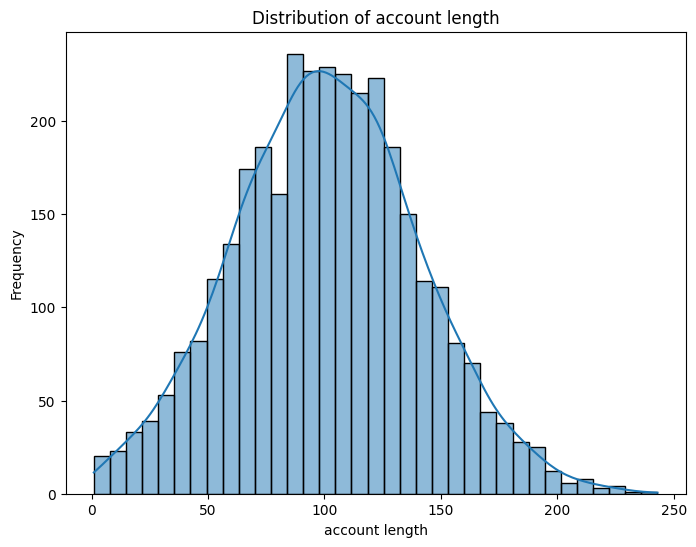

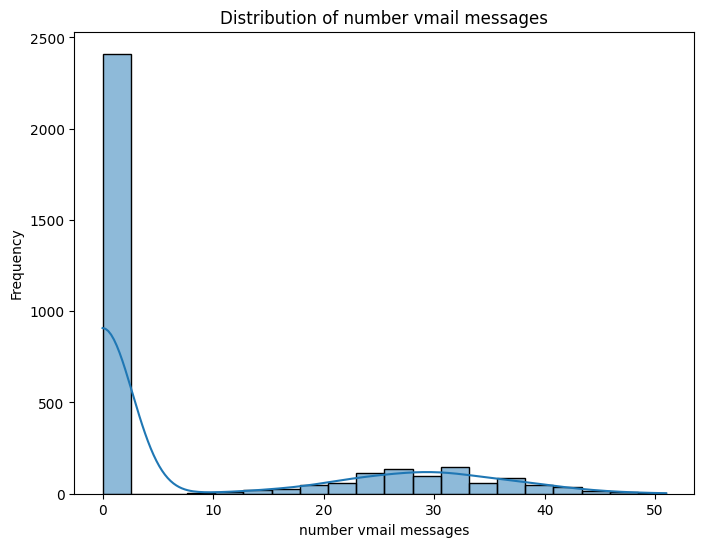

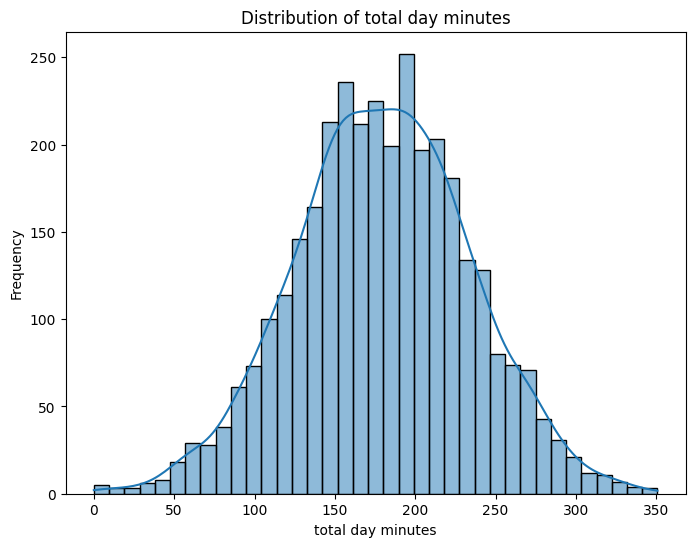

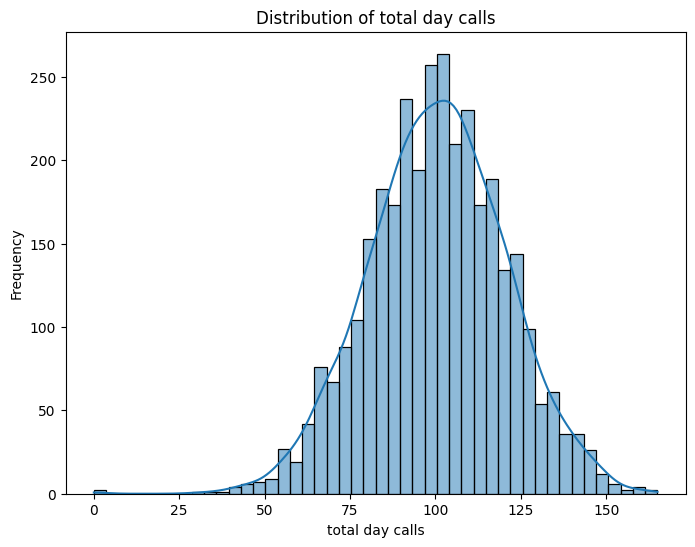

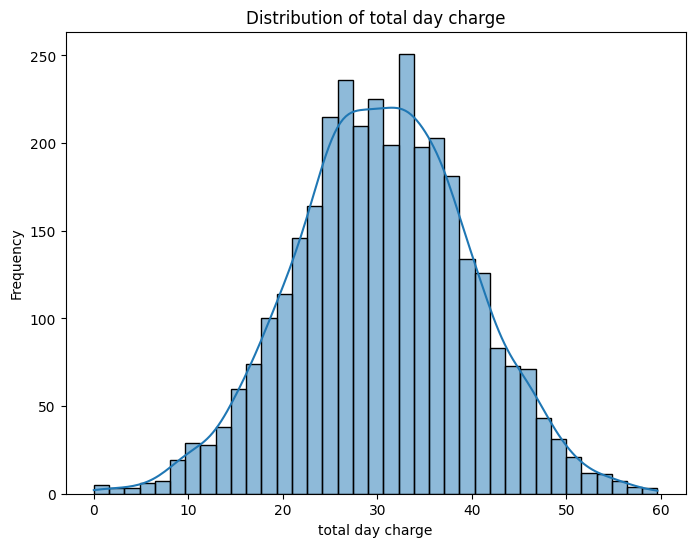

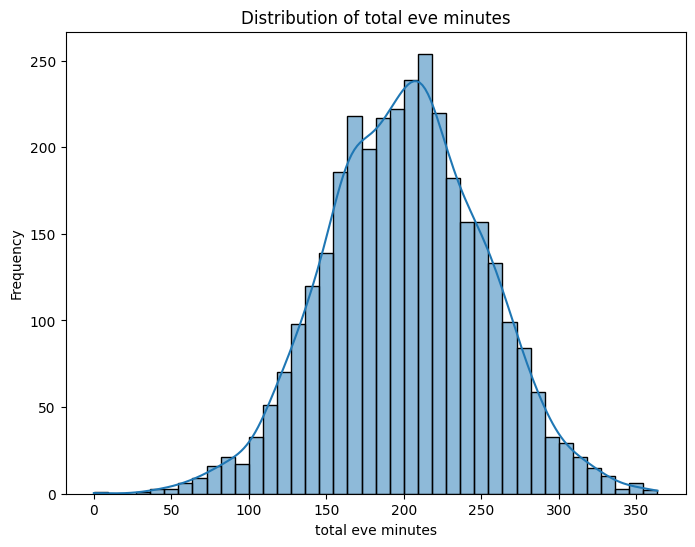

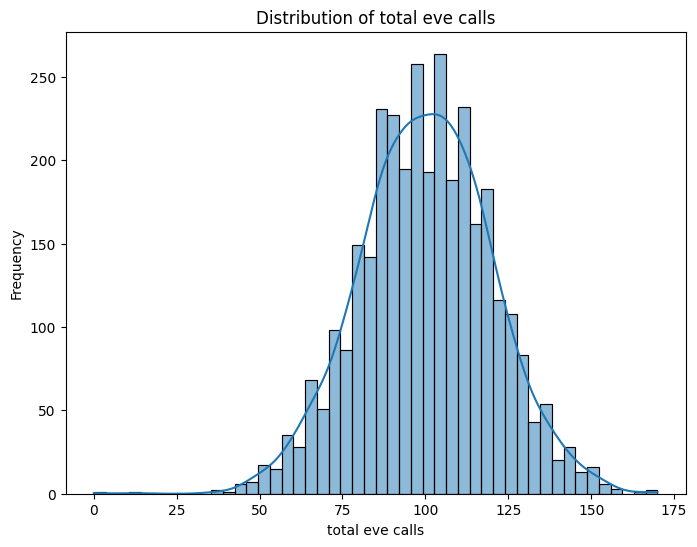

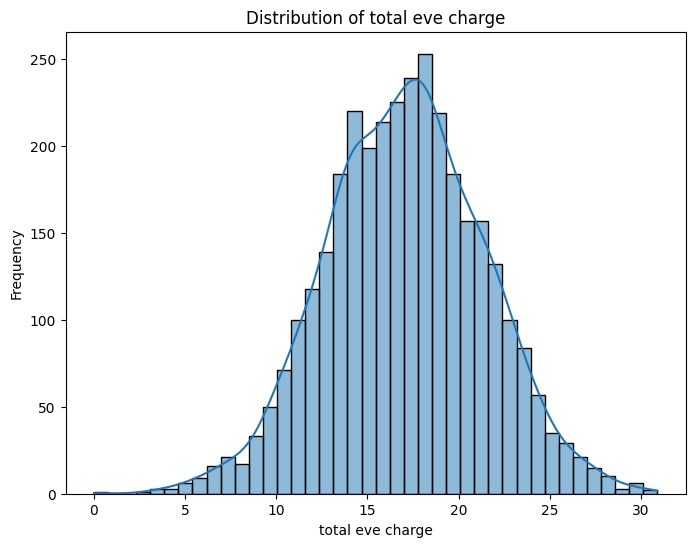

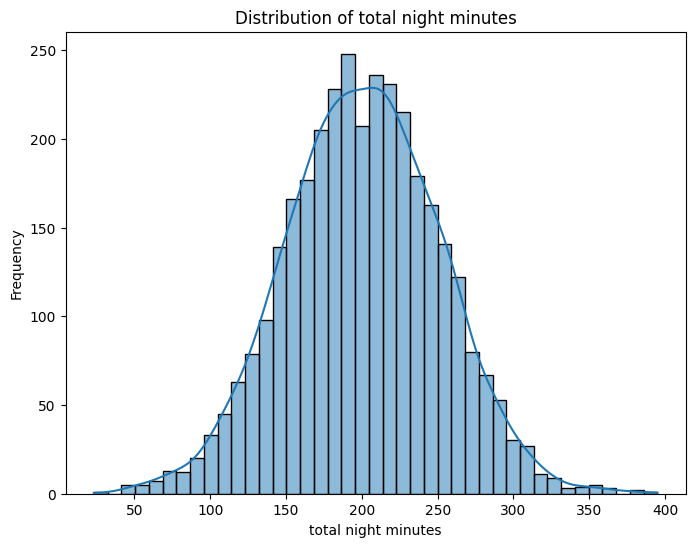

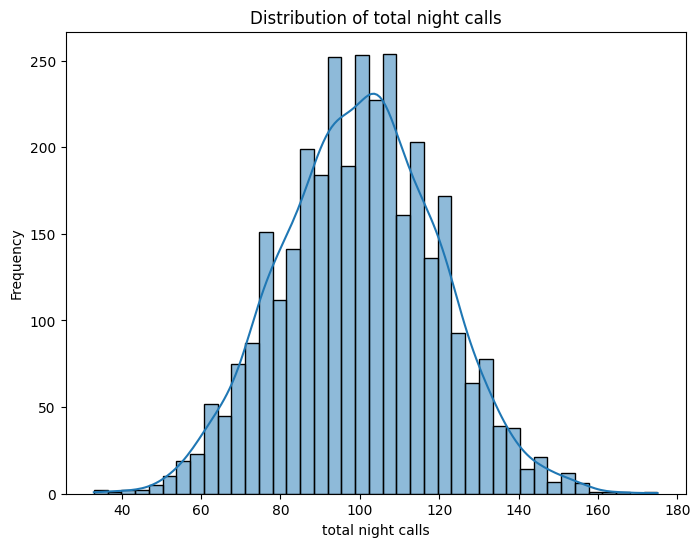

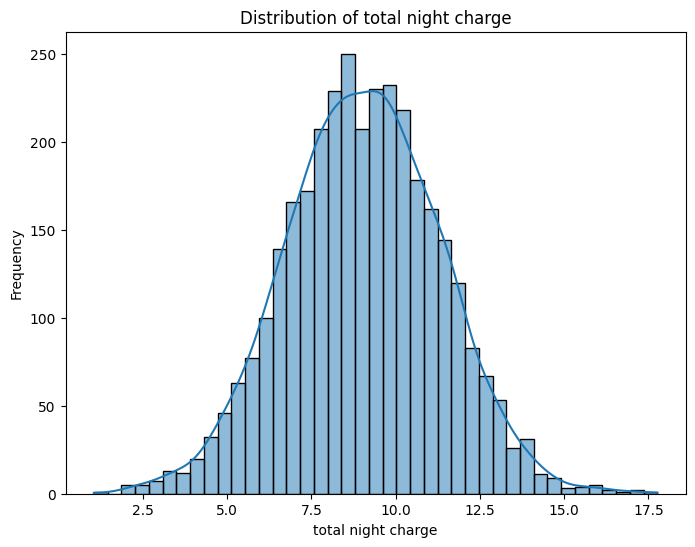

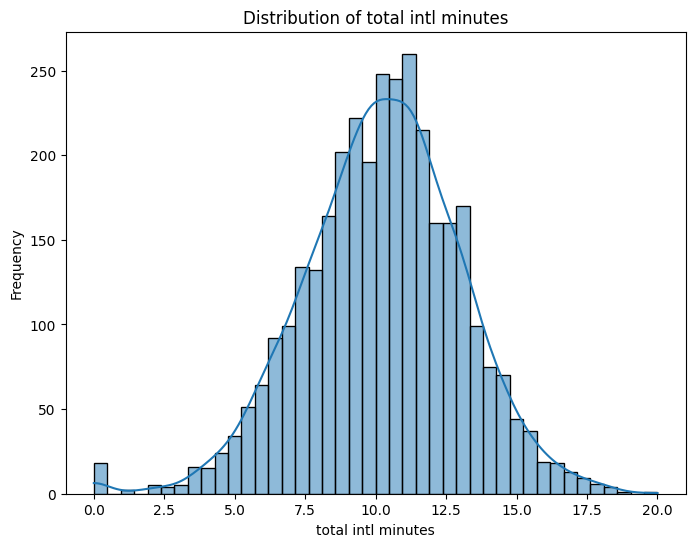

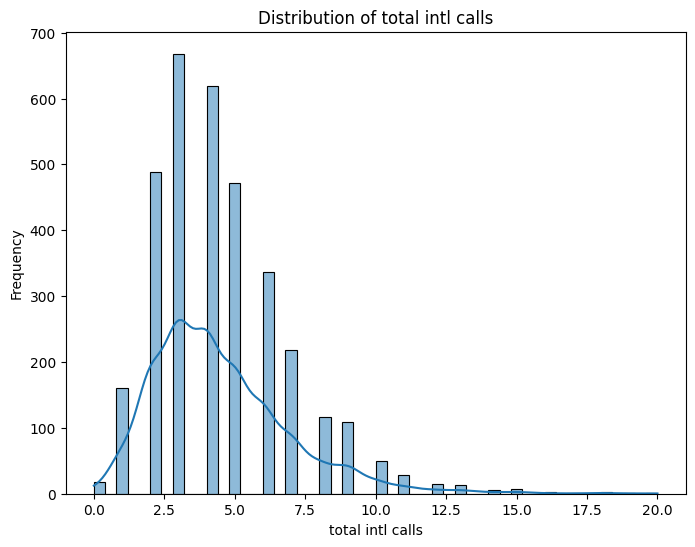

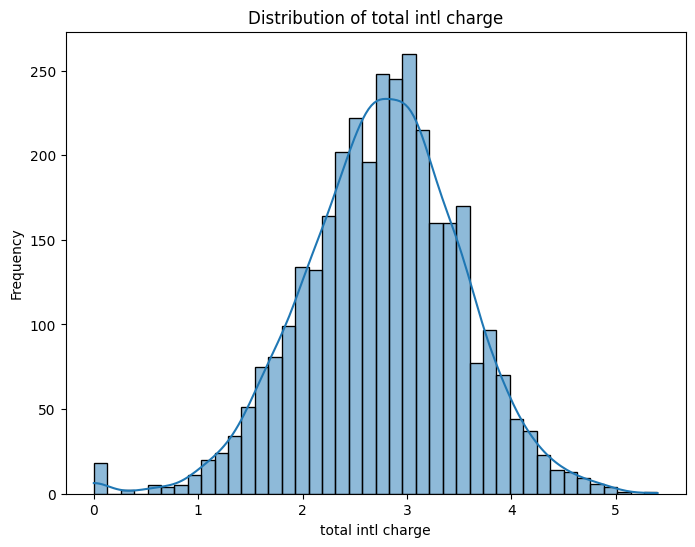

In [25]:
column_distribution(df, df_numerical_columns)

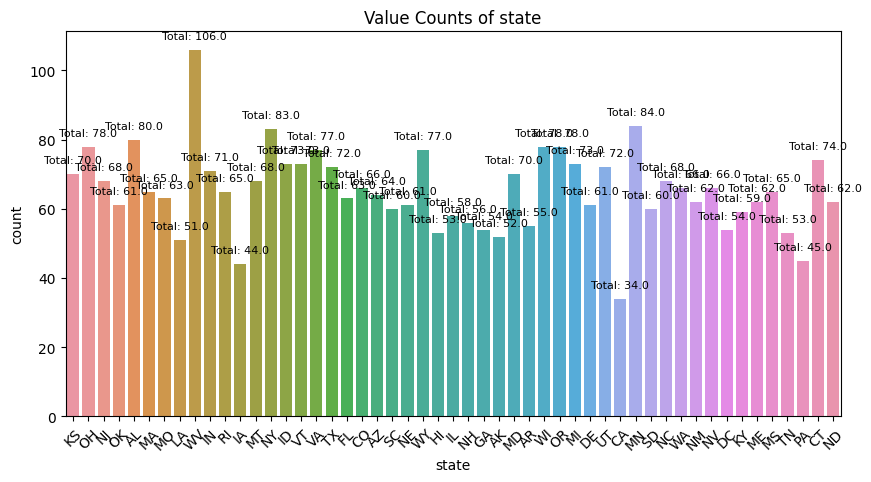

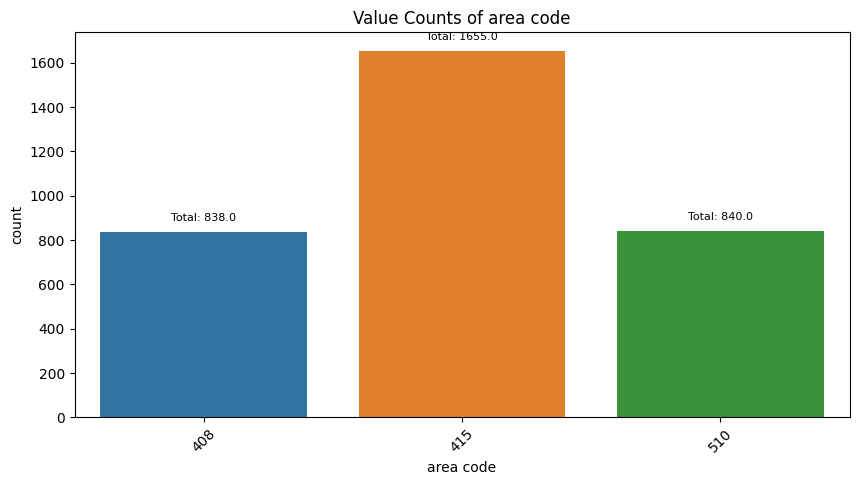

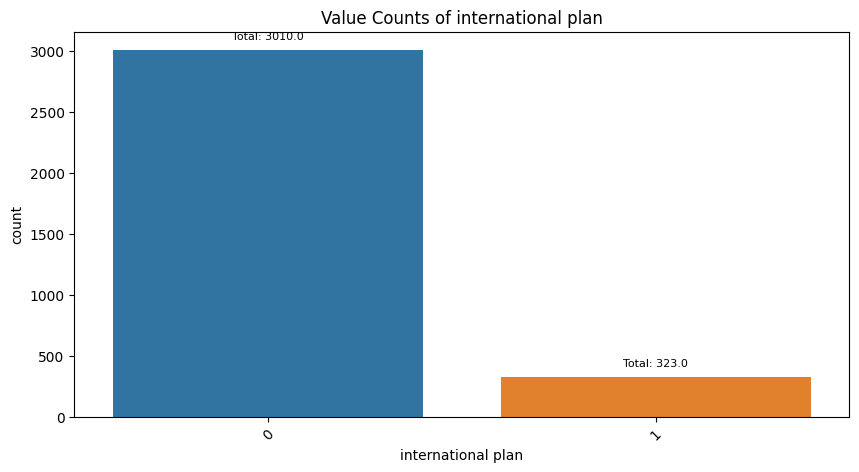

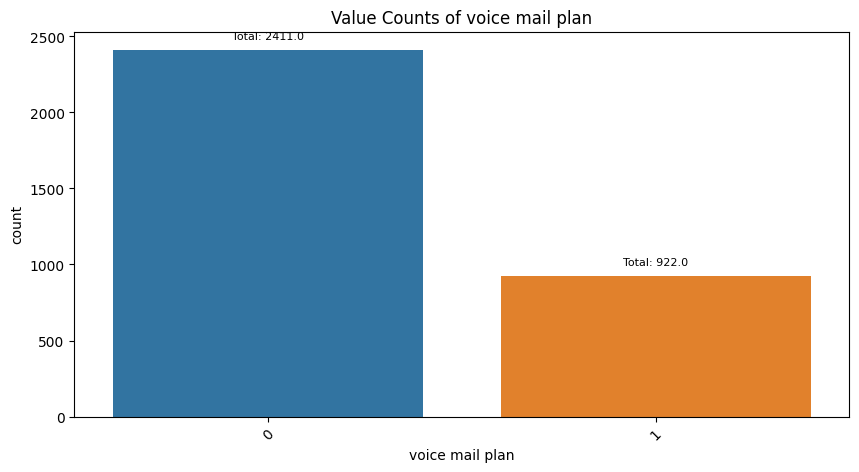

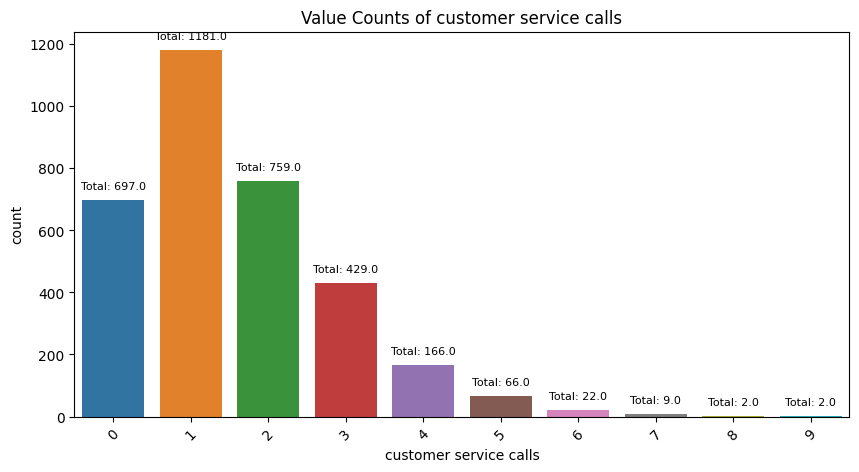

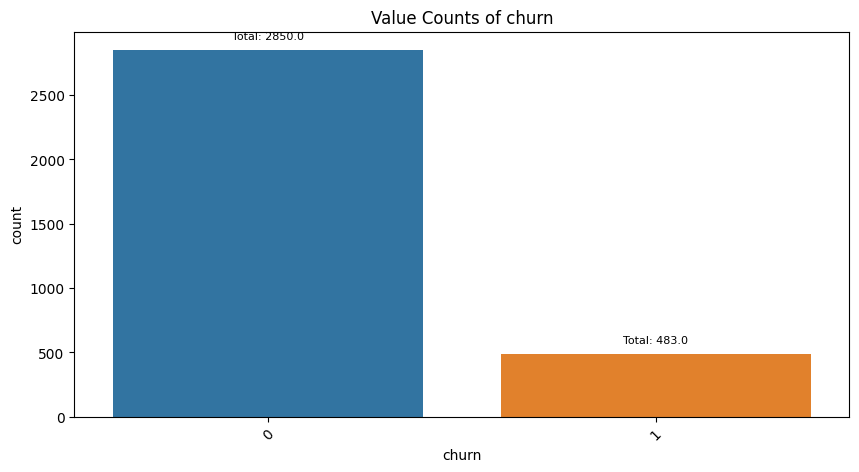

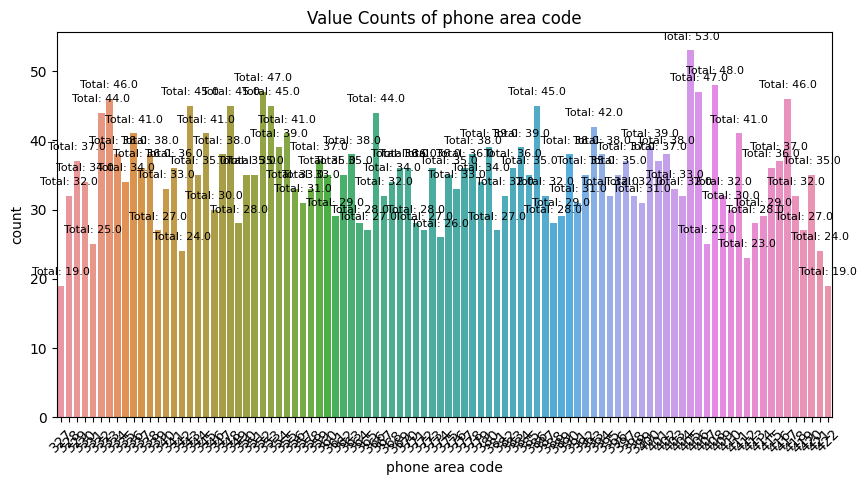

In [26]:
count_plot(df, df_categorical_columns)

### 5.0 FEATURE ENGINEERING (part 2)

In [27]:
df.columns

Index(['state', 'account length', 'area code', 'international plan',
       'voice mail plan', 'number vmail messages', 'total day minutes',
       'total day calls', 'total day charge', 'total eve minutes',
       'total eve calls', 'total eve charge', 'total night minutes',
       'total night calls', 'total night charge', 'total intl minutes',
       'total intl calls', 'total intl charge', 'customer service calls',
       'churn', 'phone area code'],
      dtype='object')

#### 5.1 Average Call Duration For Different Call Times

In [28]:
# Average Call Duration for different call types
df['avg_day_call_duration'] = df['total day minutes'] / df['total day calls']
df['avg_eve_call_duration'] = df['total eve minutes'] / df['total eve calls']
df['avg_night_call_duration'] = df['total night minutes'] / df['total night calls']
df['avg_intl_call_duration'] = df['total intl minutes'] / df['total intl calls']


#### 5.2 Total Charges per Call

In [29]:
# Total Charges per Call
df['day_charge_per_call'] = df['total day charge'] / df['total day calls']
df['eve_charge_per_call'] = df['total eve charge'] / df['total eve calls']
df['night_charge_per_call'] = df['total night charge'] / df['total night calls']
df['intl_charge_per_call'] = df['total intl charge'] / df['total intl calls']


#### 5.3 Customer Interaction index (Number of services the customer uses)

In [30]:
# Selecting the columns to be summed
cols_to_sum = [
    'customer service calls',
    'number vmail messages',
    'total day calls',
    'total eve calls',
    'total night calls',
    'total intl calls'
]

# Calculating the interaction index by summing the selected columns
df['interaction_index'] = df[cols_to_sum].sum(axis=1)


#### 5.4 Call Charge to Minute Ratio

In [31]:
# Call Charge to Minutes Ratio
df['day_charge_minute_ratio'] = df['total day charge'] / df['total day minutes']
df['eve_charge_minute_ratio'] = df['total eve charge'] / df['total eve minutes']
df['night_charge_minute_ratio'] = df['total night charge'] / df['total night minutes']
df['intl_charge_minute_ratio'] = df['total intl charge'] / df['total intl minutes']


#### 5.5 Total Activity Index

In [32]:
# Total Activity Index
df['total_activity_index'] = df[['total day minutes', 'total eve minutes', 'total night minutes', 'total intl minutes']].sum(axis=1)

In [33]:
df.shape

(3333, 35)

In [34]:
df.columns

Index(['state', 'account length', 'area code', 'international plan',
       'voice mail plan', 'number vmail messages', 'total day minutes',
       'total day calls', 'total day charge', 'total eve minutes',
       'total eve calls', 'total eve charge', 'total night minutes',
       'total night calls', 'total night charge', 'total intl minutes',
       'total intl calls', 'total intl charge', 'customer service calls',
       'churn', 'phone area code', 'avg_day_call_duration',
       'avg_eve_call_duration', 'avg_night_call_duration',
       'avg_intl_call_duration', 'day_charge_per_call', 'eve_charge_per_call',
       'night_charge_per_call', 'intl_charge_per_call', 'interaction_index',
       'day_charge_minute_ratio', 'eve_charge_minute_ratio',
       'night_charge_minute_ratio', 'intl_charge_minute_ratio',
       'total_activity_index'],
      dtype='object')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3333 entries, 3824657 to 4004344
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   state                      3333 non-null   object 
 1   account length             3333 non-null   int64  
 2   area code                  3333 non-null   int64  
 3   international plan         3333 non-null   int64  
 4   voice mail plan            3333 non-null   int64  
 5   number vmail messages      3333 non-null   int64  
 6   total day minutes          3333 non-null   float64
 7   total day calls            3333 non-null   int64  
 8   total day charge           3333 non-null   float64
 9   total eve minutes          3333 non-null   float64
 10  total eve calls            3333 non-null   int64  
 11  total eve charge           3333 non-null   float64
 12  total night minutes        3333 non-null   float64
 13  total night calls          3333 non-null   i

In [36]:
missing_values = df.isnull().sum()
# Filter columns with missing values
columns_with_missing_values = missing_values[missing_values > 0]
columns_with_missing_values

avg_day_call_duration        2
avg_eve_call_duration        1
avg_intl_call_duration      18
day_charge_per_call          2
eve_charge_per_call          1
intl_charge_per_call        18
day_charge_minute_ratio      2
eve_charge_minute_ratio      1
intl_charge_minute_ratio    18
dtype: int64

#### 5.6 Clean the df (handle the missing values)

#### 5.6.1 Imputation with zero
    Imputation with zero or specific values is suggested for columns related to charge per call 
    or charge per minute ('eve_charge_per_call', 'intl_charge_per_call', 
    'eve_charge_minute_ratio', 'intl_charge_minute_ratio') because missing values 
    might signify zero cost for calls or minutes.

In [37]:

# Imputation with zero or specific values
columns_zero_imputation = ['avg_eve_call_duration', 'eve_charge_per_call', 
                           'intl_charge_per_call', 'eve_charge_minute_ratio', 
                           'intl_charge_minute_ratio', 'avg_day_call_duration',
                           'day_charge_per_call', 'day_charge_minute_ratio']


for col in columns_zero_imputation:
    df[col].fillna(0, inplace=True)


#### 5.6.2 KNN Imputation
     Imputing international call duration might benefit from considering relationships with other features
     or users' call patterns.KNN can capture such relationships better than simple imputation methods.

In [38]:

# Select only the columns needing KNN imputation
column_knn_imputation = ['avg_intl_call_duration']

# Imputation with KNN
imputer_knn = KNNImputer(n_neighbors=5)
imputed_knn = imputer_knn.fit_transform(df[column_knn_imputation])
df[column_knn_imputation] = imputed_knn


In [39]:
missing_values = df.isnull().sum()
# Filter columns with missing values
columns_with_missing_values = missing_values[missing_values > 0]
columns_with_missing_values

Series([], dtype: int64)

#### 5.6.3 Target Encode 'state' Column

In [40]:
df.columns

Index(['state', 'account length', 'area code', 'international plan',
       'voice mail plan', 'number vmail messages', 'total day minutes',
       'total day calls', 'total day charge', 'total eve minutes',
       'total eve calls', 'total eve charge', 'total night minutes',
       'total night calls', 'total night charge', 'total intl minutes',
       'total intl calls', 'total intl charge', 'customer service calls',
       'churn', 'phone area code', 'avg_day_call_duration',
       'avg_eve_call_duration', 'avg_night_call_duration',
       'avg_intl_call_duration', 'day_charge_per_call', 'eve_charge_per_call',
       'night_charge_per_call', 'intl_charge_per_call', 'interaction_index',
       'day_charge_minute_ratio', 'eve_charge_minute_ratio',
       'night_charge_minute_ratio', 'intl_charge_minute_ratio',
       'total_activity_index'],
      dtype='object')

In [41]:
# df.state.value_counts()

In [42]:
target_encoder = ce.TargetEncoder(cols=['state'])
df['state_target_encoded'] = target_encoder.fit_transform(df['state'], df['churn'])

# Drop the original 'state' column
df.drop('state', axis=1, inplace=True)

     Reorder the df to have 'churn' as the last feature. (drop and add 'churn to df)

In [43]:
train_df = df[df.columns.drop('churn').tolist() + ['churn']]


#### 5.7 Splitting the Dataset

In [44]:

# 'test_size' specifies the proportion of the dataset to include in the test split
# 'random_state' ensures reproducibility by fixing the random seed
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

In [45]:
train_df.shape

(2499, 35)

In [46]:
test_df.shape

(834, 35)

#### 6.0 CORRELATION ANALYSIS

In [47]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2499 entries, 3501040 to 3595091
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   account length             2499 non-null   int64  
 1   area code                  2499 non-null   int64  
 2   international plan         2499 non-null   int64  
 3   voice mail plan            2499 non-null   int64  
 4   number vmail messages      2499 non-null   int64  
 5   total day minutes          2499 non-null   float64
 6   total day calls            2499 non-null   int64  
 7   total day charge           2499 non-null   float64
 8   total eve minutes          2499 non-null   float64
 9   total eve calls            2499 non-null   int64  
 10  total eve charge           2499 non-null   float64
 11  total night minutes        2499 non-null   float64
 12  total night calls          2499 non-null   int64  
 13  total night charge         2499 non-null   f

#### 6.1 Chi-Square Test For Categorical Variables

In [48]:

# selecting categorical column names from the train_df
categorical_features = ['international plan', 'voice mail plan', 'area code', 'phone area code', 'state_target_encoded', 'churn']
# Assuming categorical features are 'international plan', 'voice mail plan', 'area code', etc.
for column in categorical_features:
    contingency_table = pd.crosstab(train_df[column], train_df['churn'])
    chi2, p_val, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-Square for {column}: {chi2}, p-value: {p_val}")


Chi-Square for international plan: 181.78489158141713, p-value: 1.97567932631883e-41
Chi-Square for voice mail plan: 21.232854396522608, p-value: 4.0673242684554415e-06
Chi-Square for area code: 1.4868651813053684, p-value: 0.47547898638091335
Chi-Square for phone area code: 93.46190221618726, p-value: 0.5254107835063032
Chi-Square for state_target_encoded: 67.46698490128972, p-value: 0.026724367017893626
Chi-Square for churn: 2490.8589825796107, p-value: 0.0


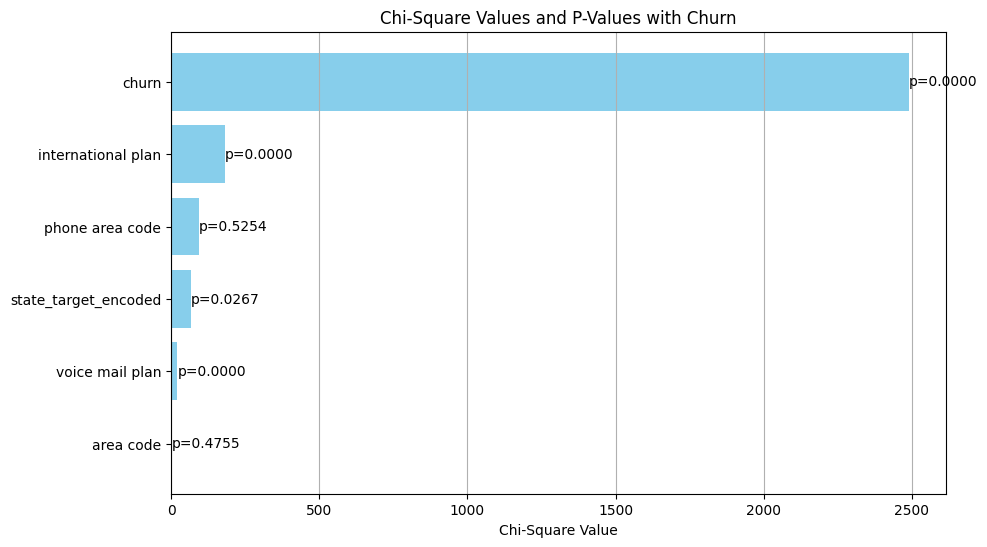

In [49]:
categorical_features = [
    'international plan', 'voice mail plan', 'area code', 
    'phone area code', 'state_target_encoded', 'churn'
]

chi2_values = []
p_values = []  # To store p-values

for column in categorical_features:
    contingency_table = pd.crosstab(train_df[column], train_df['churn'])
    chi2, p_val, _, _ = chi2_contingency(contingency_table)
    chi2_values.append(chi2)
    p_values.append(p_val)

# Sort features based on Chi-Square values in descending order
sorted_indices = sorted(range(len(chi2_values)), key=lambda k: chi2_values[k], reverse=False)
sorted_features = [categorical_features[i] for i in sorted_indices]
sorted_chi2_values = [chi2_values[i] for i in sorted_indices]
sorted_p_values = [p_values[i] for i in sorted_indices]

# Plotting the Chi-Square values and p-values for each categorical feature in descending order
plt.figure(figsize=(10, 6))
bar_plot = plt.barh(sorted_features, sorted_chi2_values, color='skyblue')
plt.xlabel('Chi-Square Value')
plt.title('Chi-Square Values and P-Values with Churn')
plt.grid(axis='x')

# Adding p-values as text labels on the plot
for i, v in enumerate(sorted_chi2_values):
    plt.text(v + 0.01, i, f'p={sorted_p_values[i]:.4f}', color='black', va='center')

plt.show()


#### 6.2 Point-Biserial Correlation

In [50]:


numeric_features = [
    'account length', 'number vmail messages', 'total day minutes', 'total day calls',
    'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge',
    'total night minutes', 'total night calls', 'total night charge', 'total intl minutes',
    'total intl calls', 'total intl charge', 'customer service calls', 'avg_day_call_duration',
    'avg_eve_call_duration', 'avg_night_call_duration', 'avg_intl_call_duration',
    'day_charge_per_call', 'eve_charge_per_call', 'night_charge_per_call', 'intl_charge_per_call',
    'interaction_index', 'day_charge_minute_ratio', 'eve_charge_minute_ratio',
    'night_charge_minute_ratio', 'intl_charge_minute_ratio', 'total_activity_index'
]

for column in numeric_features:
    point_biserial_corr, p_val = pointbiserialr(train_df[column], train_df['churn'])
    print(f"Point-Biserial Correlation for {column}: {point_biserial_corr}, p-value: {p_val}")


Point-Biserial Correlation for account length: 0.02079878420395598, p-value: 0.2986543433739431
Point-Biserial Correlation for number vmail messages: -0.08487406762373378, p-value: 2.1530354696618663e-05
Point-Biserial Correlation for total day minutes: 0.1851409524662901, p-value: 1.0453513274952157e-20
Point-Biserial Correlation for total day calls: 0.0024521825152906736, p-value: 0.9024844717331973
Point-Biserial Correlation for total day charge: 0.1851430206552027, p-value: 1.0443054719129686e-20
Point-Biserial Correlation for total eve minutes: 0.08436424909847763, p-value: 2.412983776328675e-05
Point-Biserial Correlation for total eve calls: 0.013580771427742121, p-value: 0.4973949066612294
Point-Biserial Correlation for total eve charge: 0.08435057743702276, p-value: 2.4203496932027217e-05
Point-Biserial Correlation for total night minutes: 0.02253805772974093, p-value: 0.26005682070106423
Point-Biserial Correlation for total night calls: 0.0061739950535835714, p-value: 0.757712

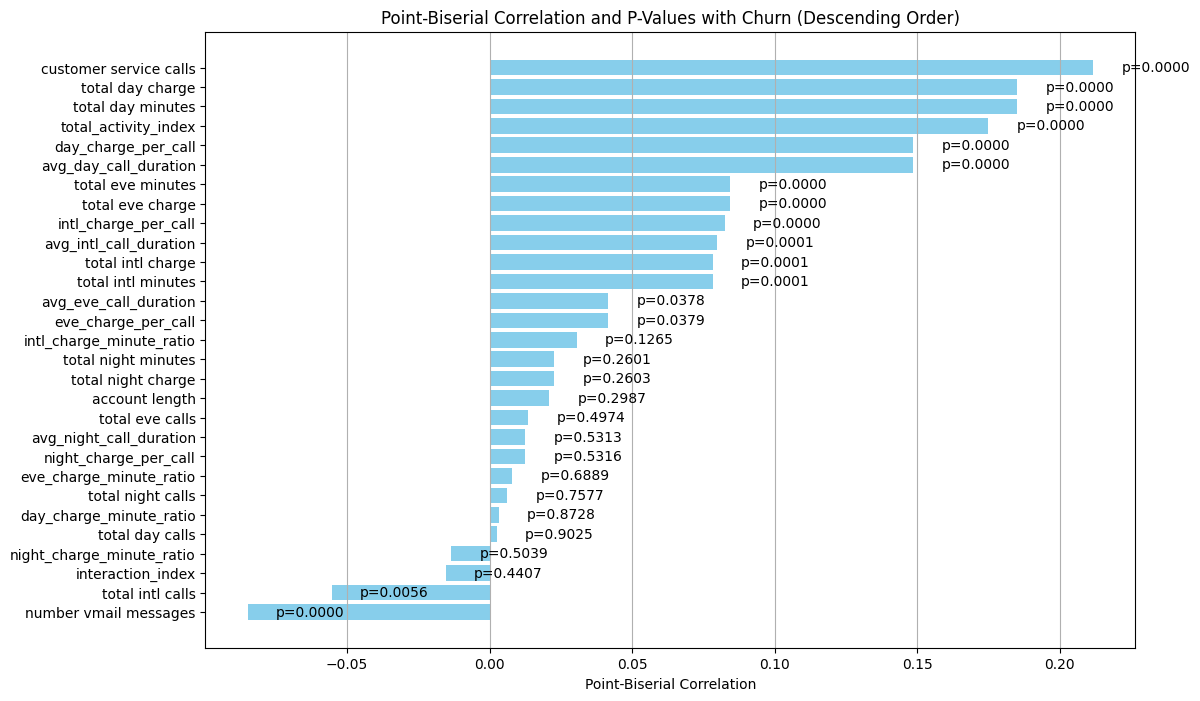

In [51]:

numeric_features = [
    'account length', 'number vmail messages', 'total day minutes', 'total day calls',
    'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge',
    'total night minutes', 'total night calls', 'total night charge', 'total intl minutes',
    'total intl calls', 'total intl charge', 'customer service calls', 'avg_day_call_duration',
    'avg_eve_call_duration', 'avg_night_call_duration', 'avg_intl_call_duration',
    'day_charge_per_call', 'eve_charge_per_call', 'night_charge_per_call', 'intl_charge_per_call',
    'interaction_index', 'day_charge_minute_ratio', 'eve_charge_minute_ratio',
    'night_charge_minute_ratio', 'intl_charge_minute_ratio', 'total_activity_index'
]

correlation_values = []
p_values = []  # To store p-values

for column in numeric_features:
    point_biserial_corr, p_val = pointbiserialr(train_df[column], train_df['churn'])
    correlation_values.append(point_biserial_corr)
    p_values.append(p_val)

# Sort features based on correlation values in descending order
sorted_indices = sorted(range(len(correlation_values)), key=lambda k: correlation_values[k], reverse=False)
sorted_features = [numeric_features[i] for i in sorted_indices]
sorted_corr_values = [correlation_values[i] for i in sorted_indices]
sorted_p_values = [p_values[i] for i in sorted_indices]

# Plotting the Point-Biserial Correlation values and p-values for each numeric feature in descending order
plt.figure(figsize=(12, 8))
bar_plot = plt.barh(sorted_features, sorted_corr_values, color='skyblue')
plt.xlabel('Point-Biserial Correlation')
plt.title('Point-Biserial Correlation and P-Values with Churn (Descending Order)')
plt.grid(axis='x')

# Adding p-values as text labels on the plot
for i, v in enumerate(sorted_corr_values):
    plt.text(v + 0.01, i, f'p={sorted_p_values[i]:.4f}', color='black', va='center')

plt.show()


#### 6.2.1 Function to filter df using a specified p-value

In [52]:
def select_feature_by_df(train_df, p_value_threshold):
    # Initialize an empty list to store selected features
    selected_features = []
    
    # Calculate chi-squared test for each column (assuming they are categorical)
    for column in train_df.columns:
        contingency_table = pd.crosstab(train_df[column], train_df['churn'])  # 'churn' is the target column
        _, p_val, _, _ = chi2_contingency(contingency_table)
        
        # Check if p-value is less than the threshold and add the feature to the selected list
        if p_val <= p_value_threshold:
            selected_features.append(column)
    
    # Create the filtered DataFrame using the selected features
    filtered_df = train_df[selected_features]
    
    return filtered_df


In [53]:
filtered_df = select_feature_by_df(train_df, 0.05)


In [54]:
filtered_df.shape

(2499, 12)

In [55]:
filtered_df.columns

Index(['international plan', 'voice mail plan', 'total day minutes',
       'total day charge', 'total intl minutes', 'total intl calls',
       'total intl charge', 'customer service calls', 'churn',
       'day_charge_minute_ratio', 'intl_charge_minute_ratio',
       'state_target_encoded'],
      dtype='object')

#### 7.0 COLLINEARITY ANALYSIS

In [56]:

def check_collinearity(df, threshold=0.7):
    # Calculate the correlation matrix
    correlation_matrix = df.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    )
    
    # Find index of feature columns with correlation greater than threshold
    collinear_features = [(column, col) for column in upper.columns for col in upper.columns 
                          if upper[column][col] > threshold and column != col]
    
    # Get the correlated values
    correlated_values = [upper[column][col] for column, col in collinear_features]
    
    # Create a DataFrame of correlated pairs and their correlation coefficients
    collinear_df = pd.DataFrame({'Pair 1': [pair[0] for pair in collinear_features],
                                 'Pair 2': [pair[1] for pair in collinear_features],
                                 'Correlation': correlated_values})
    
    return collinear_df


In [57]:
collinearity_results = check_collinearity(filtered_df, threshold=0.7)

collinearity_results

,Pair 1,Pair 2,Correlation
0,total day charge,total day minutes,1.000000
1,total intl charge,total intl minutes,0.999993


In [58]:

def collinearity_checker(df, threshold):
    # Calculate the correlation matrix
    correlation_matrix = df.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    )
    
    # Find feature pairs with correlation greater than threshold
    collinear_pairs = [(column, col) for column in upper.columns for col in upper.columns 
                          if upper[column][col] > threshold and column != col]
    
    # Get the correlated values
    correlated_values = [upper[column][col] for column, col in collinear_pairs]
    
    # Create a DataFrame of correlated pairs and their correlation coefficients
    collinear_df = pd.DataFrame({'Feature Pair': [f"{pair[0]} - {pair[1]}" for pair in collinear_pairs],
                                 'Collinearity Score': correlated_values})
    
    # Sort by collinearity score in descending order
    collinear_df = collinear_df.sort_values(by='Collinearity Score', ascending=False)
    
    # Plotting collinearity scores
    plt.figure(figsize=(10, 8))
    plt.barh(collinear_df['Feature Pair'], collinear_df['Collinearity Score'], color='skyblue')
    plt.xlabel('Collinearity Score')
    plt.title('Collinearity of Feature Pairs')
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.show()




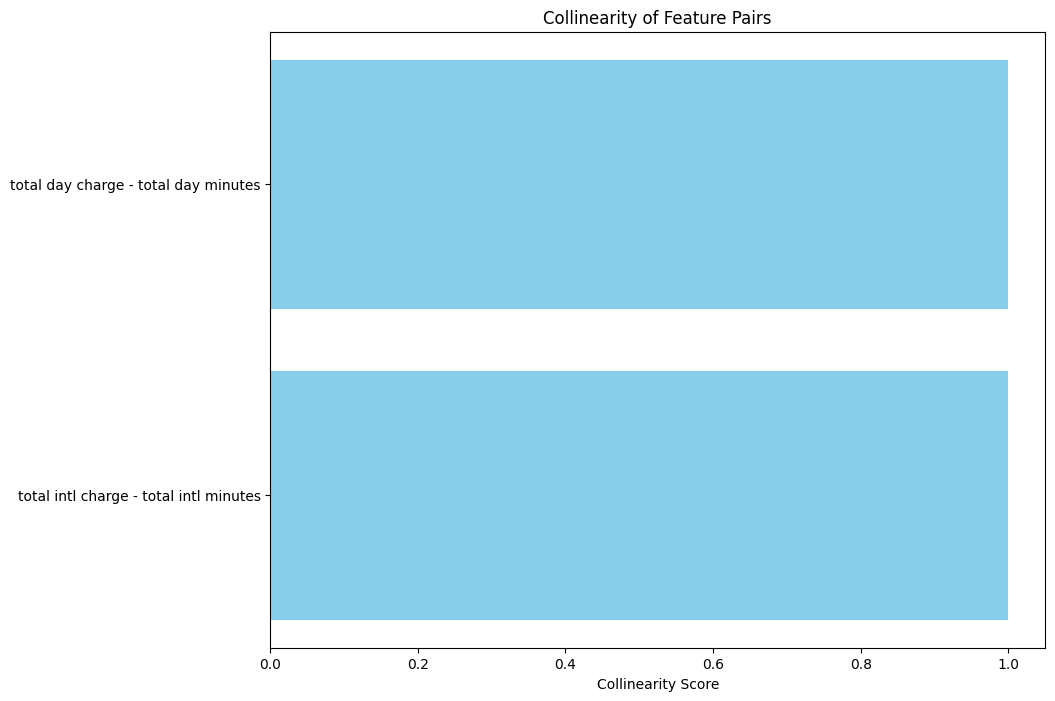

In [59]:
# Initialize the function with filtered_df and threshold
clean_df = collinearity_checker(filtered_df, threshold=0.7)

In [60]:

def remove_collinear_features(df, threshold, target_variable='churn'):
    # Calculate the correlation matrix
    correlation_matrix = df.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    )
    
    # Find feature pairs with correlation greater than threshold
    collinear_pairs = [(column, col) for column in upper.columns for col in upper.columns 
                       if upper[column][col] > threshold and column != col]
    
    features_to_drop = set()
    
    # Determine which feature to drop based on target correlation
    for feature1, feature2 in collinear_pairs:
        if feature1 not in features_to_drop and feature2 not in features_to_drop:
            corr_target_1 = df[feature1].corr(df[target_variable])
            corr_target_2 = df[feature2].corr(df[target_variable])
            
            if corr_target_1 > corr_target_2:
                features_to_drop.add(feature2)
                print(f"Highly collinear combo: {feature1} and {feature2}")
                print(f"Features dropped: {feature2} in favor of highly correlated {feature1}")
            else:
                features_to_drop.add(feature1)
                print(f"Highly collinear combo: {feature1} and {feature2}")
                print(f"Features dropped: {feature1} in favor of highly correlated {feature2}")
    
    # Drop the selected features
    df_clean = df.drop(columns=features_to_drop)
    
    return df_clean



In [61]:
# Initialize the function with filtered_df and threshold
clean_df = remove_collinear_features(filtered_df, threshold=0.7)



Highly collinear combo: total day charge and total day minutes
Features dropped: total day minutes in favor of highly correlated total day charge
Highly collinear combo: total intl charge and total intl minutes
Features dropped: total intl minutes in favor of highly correlated total intl charge


In [62]:
clean_df.shape

(2499, 10)

#### 8.0 HANDLING CLASS IMBALANCE

#### 8.1 APPLYING SMOTE

In [63]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2499 entries, 3501040 to 3595091
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   international plan        2499 non-null   int64  
 1   voice mail plan           2499 non-null   int64  
 2   total day charge          2499 non-null   float64
 3   total intl calls          2499 non-null   int64  
 4   total intl charge         2499 non-null   float64
 5   customer service calls    2499 non-null   int64  
 6   churn                     2499 non-null   int32  
 7   day_charge_minute_ratio   2499 non-null   float64
 8   intl_charge_minute_ratio  2499 non-null   float64
 9   state_target_encoded      2499 non-null   float64
dtypes: float64(5), int32(1), int64(4)
memory usage: 195.2 KB


In [64]:
def apply_smote(df):
    # Separate features and target variable
    X = df.drop('churn', axis=1)  # Features
    y = df['churn']  # Target variable

    # Apply SMOTE and convert the resampled arrays to DataFrames
    X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X, y)
    X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
    y_resampled_df = pd.Series(y_resampled, name='churn')
    
    return pd.concat([X_resampled_df, y_resampled_df], axis=1)


In [65]:
resampled_df = apply_smote(clean_df)


In [66]:
resampled_df.churn.value_counts()

churn
0    2141
1    2141
Name: count, dtype: int64

### 8.2 DIMENSIONALITY REDUCTION

#### 8.2.1 PCA Analysis

    This is to determine the n-components for my PCA

In [67]:


def visualize_explained_variance(df):
    # Selecting only numeric columns
    features = df.select_dtypes(include=['int', 'float']).drop('churn', axis=1)

    # Standardizing the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # PCA
    pca = PCA()
    pca_obj = pca.fit(scaled_features)

    # Plotting the explained variance ratio
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             pca.explained_variance_ratio_, marker='o', linestyle='--')
    plt.xlabel('Number of Components')
    plt.ylabel('Variance Ratio')
    plt.title('Variance Ratio per Number of Components')
    plt.grid()
    plt.show()




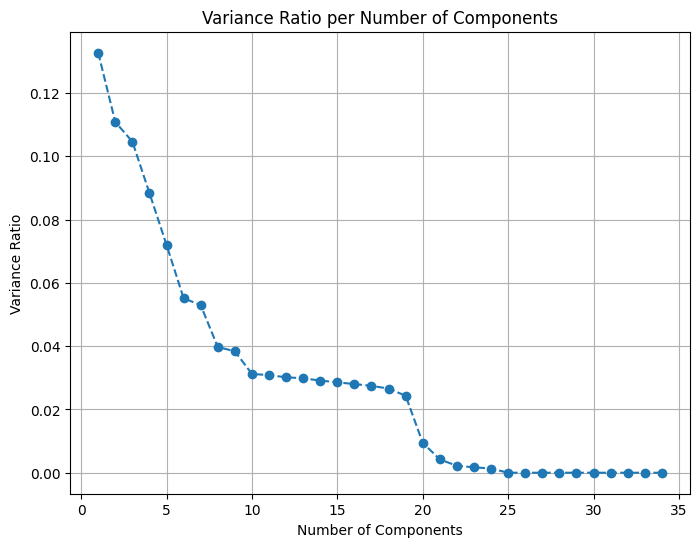

In [68]:
#usage with 'train_df'
visualize_explained_variance(train_df)

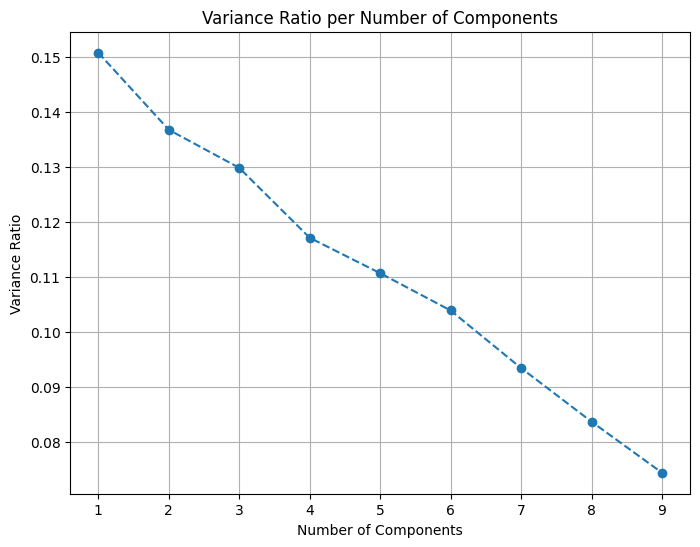

In [69]:
# Usage with 'resampled_df'
visualize_explained_variance(resampled_df)

#### 8.3. KEY FEATURES THAT DETERMINE CUSTOMER CHURN RATE

In [96]:
resampled_df.columns

Index(['international plan', 'voice mail plan', 'total day charge',
       'total intl calls', 'total intl charge', 'customer service calls',
       'day_charge_minute_ratio', 'intl_charge_minute_ratio',
       'state_target_encoded', 'churn'],
      dtype='object')

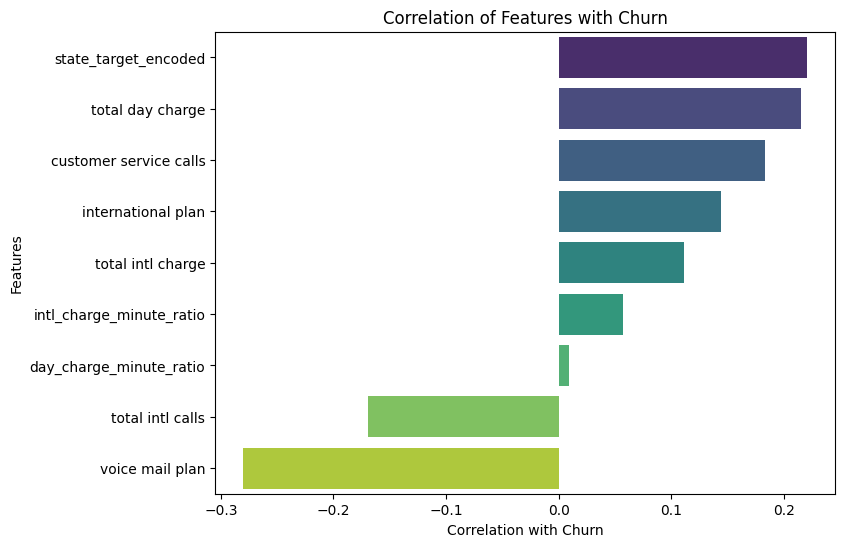

In [97]:

# Compute the correlation of all columns with 'churn'
correlation = resampled_df.corr()['churn'].drop('churn')  # Remove correlation with itself

# Sort the correlations in descending order
correlation = correlation.sort_values(ascending=False)

# Plotting the correlations
plt.figure(figsize=(8, 6))
sns.barplot(x=correlation.values, y=correlation.index, palette='viridis')
plt.xlabel('Correlation with Churn')
plt.ylabel('Features')
plt.title('Correlation of Features with Churn')
plt.show()


#### 9.0 MODELING

In [70]:
def clean_test_df(old_test_df, new_train_df):
    # Get column intersection between new_train_df and old_test_df
    common_columns = new_train_df.columns.intersection(old_test_df.columns)
    
    # Filter the old_test_df using the common columns
    new_test_df = old_test_df[common_columns]
    
    return new_test_df



In [71]:
# Initialize the function with old_test_df and new_train_df
new_test_df = clean_test_df(test_df, resampled_df)


In [72]:
new_test_df.shape

(834, 10)

In [73]:
new_test_df.churn.value_counts()

churn
0    709
1    125
Name: count, dtype: int64

In [74]:
resampled_df.shape

(4282, 10)

In [75]:
resampled_df.churn.value_counts()

churn
0    2141
1    2141
Name: count, dtype: int64

In [76]:
new_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 834 entries, 3526573 to 3561567
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   international plan        834 non-null    int64  
 1   voice mail plan           834 non-null    int64  
 2   total day charge          834 non-null    float64
 3   total intl calls          834 non-null    int64  
 4   total intl charge         834 non-null    float64
 5   customer service calls    834 non-null    int64  
 6   day_charge_minute_ratio   834 non-null    float64
 7   intl_charge_minute_ratio  834 non-null    float64
 8   state_target_encoded      834 non-null    float64
 9   churn                     834 non-null    int32  
dtypes: float64(5), int32(1), int64(4)
memory usage: 65.2 KB


#### 9.1 LOGISTIC REGRESSION

In [77]:


# Define RFE and PolynomialFeatures steps
rfe = RFE(estimator=LogisticRegression())
poly_features = PolynomialFeatures(degree=2)

# Create a feature union for RFE and PolynomialFeatures
feature_union = FeatureUnion([
    ('rfe', rfe),
    ('poly_features', poly_features)
])

# Modify the Logistic Regression pipeline
logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('features', feature_union),  # Include feature selection and engineering
    ('pca', PCA()),
    ('classifier', LogisticRegression())
])

# Define the updated parameter grid for GridSearchCV
param_grid = {
    'features__rfe__n_features_to_select': [5, 10],  # Number of features to select using RFE
    'pca__n_components': [9],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'classifier__solver': ['liblinear'],
    'classifier__max_iter': [100, 200, 300, 400],
    'classifier__random_state': [42],
}

# Define scoring metrics for GridSearchCV
scoring = {'accuracy': 'accuracy', 'f1_score': 'f1'}

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=logistic_pipeline,
    param_grid=param_grid,
    scoring=scoring,
    cv=3,  # 5-fold cross-validation
    refit='accuracy',  # Refit using accuracy for best estimator
    n_jobs=-1,  # Use all available processors
)

# Train the model on the resampled training data (replace X_train and y_train with your data)
grid_search.fit(resampled_df.drop('churn', axis=1), resampled_df['churn'])

# Get the best estimator
best_model = grid_search.best_estimator_

# Predict on the new_test_df using the best model
new_test_predictions = best_model.predict(new_test_df.drop('churn', axis=1))

# Calculate accuracy and F1-score on the new_test_df (replace y_true with true labels)
accuracy = accuracy_score(new_test_df['churn'], new_test_predictions)
f1 = f1_score(new_test_df['churn'], new_test_predictions)

print(f'Accuracy on test set: {accuracy:.4f}')
print(f'F1-score on test set: {f1:.4f}')

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best estimator
best_model = grid_search.best_estimator_


Accuracy on test set: 0.7842
F1-score on test set: 0.5161
Best Parameters: {'classifier__C': 1.0, 'classifier__max_iter': 200, 'classifier__penalty': 'l2', 'classifier__random_state': 42, 'classifier__solver': 'liblinear', 'features__rfe__n_features_to_select': 5, 'pca__n_components': 9}


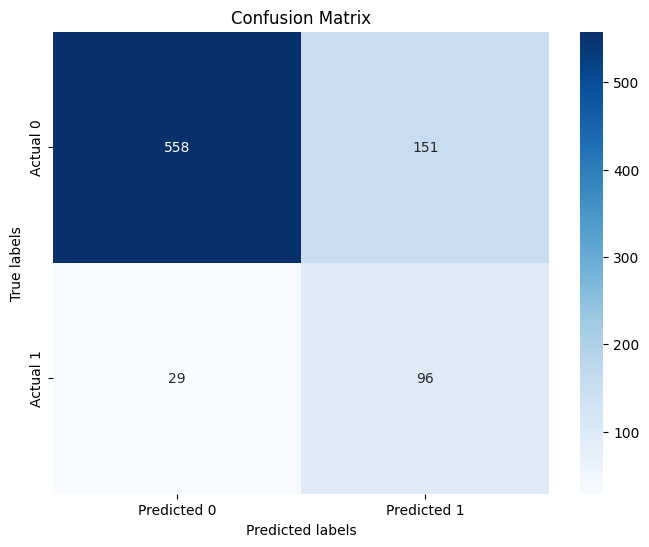

In [78]:

# Generate confusion matrix
conf_matrix = confusion_matrix(new_test_df['churn'], new_test_predictions)

# Create a heatmap for the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


#### Confusion Matrix Function

In [79]:

def plot_confusion_matrix(model, test_df):
    # Predictions using the provided model
    y_true = test_df['churn']
    X_test = test_df.drop('churn', axis=1)
    y_pred = model.predict(X_test)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Set the color map for the confusion matrix
    cmap = sns.color_palette("pastel", as_cmap=True)  # Use 'pastel' color palette
    
    # Plotting the confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()


#### 9.2 DECISION TREE CLASSIFIER

In [80]:

# Define a Decision Tree pipeline with feature scaling and PCA for dimensionality reduction
tree_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('pca', PCA(n_components=9)),  # PCA for dimensionality reduction with best param value
    ('tree', DecisionTreeClassifier(criterion='gini', max_depth=None, max_features=None, min_samples_leaf=1,
                                    min_samples_split=2, splitter='best'))  # Decision Tree classifier with best param values
])

# Train the model on the resampled training data using the best parameters from KNN
tree_pipeline.fit(resampled_df.drop('churn', axis=1), resampled_df['churn'])

# Predict on the new_test_df using the decision tree model
new_test_predictions_tree = tree_pipeline.predict(new_test_df.drop('churn', axis=1))

# Calculate accuracy and F1-score on the new_test_df
accuracy_tree = accuracy_score(new_test_df['churn'], new_test_predictions_tree)
f1_tree = f1_score(new_test_df['churn'], new_test_predictions_tree)

print(f'Accuracy on test set (Decision Tree): {accuracy_tree:.4f}')
print(f'F1-score on test set (Decision Tree): {f1_tree:.4f}')


Accuracy on test set (Decision Tree): 0.7698
F1-score on test set (Decision Tree): 0.4637


In [81]:
# Calculate accuracy, precision, recall, and F1-score on the new_test_df for Decision Tree
accuracy_tree = accuracy_score(new_test_df['churn'], new_test_predictions_tree)
precision_tree = precision_score(new_test_df['churn'], new_test_predictions_tree)
recall_tree = recall_score(new_test_df['churn'], new_test_predictions_tree)
f1_tree = f1_score(new_test_df['churn'], new_test_predictions_tree)

print(f'Accuracy on test set (Decision Tree): {accuracy_tree:.4f}')
print(f'Precision on test set (Decision Tree): {precision_tree:.4f}')
print(f'Recall on test set (Decision Tree): {recall_tree:.4f}')
print(f'F1-score on test set (Decision Tree): {f1_tree:.4f}')

Accuracy on test set (Decision Tree): 0.7698
Precision on test set (Decision Tree): 0.3562
Recall on test set (Decision Tree): 0.6640
F1-score on test set (Decision Tree): 0.4637


#### 9.3 KNN's

In [82]:


# Create a KNN pipeline with feature scaling and PCA for dimensionality reduction
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('pca', PCA()),  # PCA for dimensionality reduction
    ('knn', KNeighborsClassifier())  # KNN classifier
])

# Define the parameter grid for GridSearchCV
param_grid_knn = {
    'pca__n_components': [9],  # Modify PCA components
    'knn__n_neighbors': [15, 20, 25],  # Modify number of neighbors
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

# Create GridSearchCV object for KNN with stratified cross-validation
grid_search_knn = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=param_grid_knn,
    scoring='accuracy',
    cv=StratifiedKFold(n_splits=5, shuffle=True),  # Stratified cross-validation
    n_jobs=-1,
    error_score='raise'
)

# Train the model on the resampled training data
grid_search_knn.fit(resampled_df.drop('churn', axis=1), resampled_df['churn'])

# Get the best estimator
best_knn_model = grid_search_knn.best_estimator_

# Predict on the new_test_df using the best model
new_test_predictions_knn = best_knn_model.predict(new_test_df.drop('churn', axis=1))

# Calculate accuracy and F1-score on the new_test_df
accuracy_knn = accuracy_score(new_test_df['churn'], new_test_predictions_knn)
f1_knn = f1_score(new_test_df['churn'], new_test_predictions_knn)

print(f'Accuracy on test set (KNN): {accuracy_knn:.4f}')
print(f'F1-score on test set (KNN): {f1_knn:.4f}')
# Print best estimator's parameter values
print("Best Estimator's Parameters:")
print(grid_search_knn.best_params_)



Accuracy on test set (KNN): 0.8237
F1-score on test set (KNN): 0.5532
Best Estimator's Parameters:
{'knn__n_neighbors': 15, 'knn__p': 1, 'knn__weights': 'distance', 'pca__n_components': 9}


In [83]:
# Calculate accuracy, precision, recall, and F1-score on the new_test_df for KNN
accuracy_knn = accuracy_score(new_test_df['churn'], new_test_predictions_knn)
precision_knn = precision_score(new_test_df['churn'], new_test_predictions_knn)
recall_knn = recall_score(new_test_df['churn'], new_test_predictions_knn)
f1_knn = f1_score(new_test_df['churn'], new_test_predictions_knn)

print(f'Accuracy on test set (KNN): {accuracy_knn:.4f}')
print(f'Precision on test set (KNN): {precision_knn:.4f}')
print(f'Recall on test set (KNN): {recall_knn:.4f}')
print(f'F1-score on test set (KNN): {f1_knn:.4f}')

Accuracy on test set (KNN): 0.8237
Precision on test set (KNN): 0.4461
Recall on test set (KNN): 0.7280
F1-score on test set (KNN): 0.5532


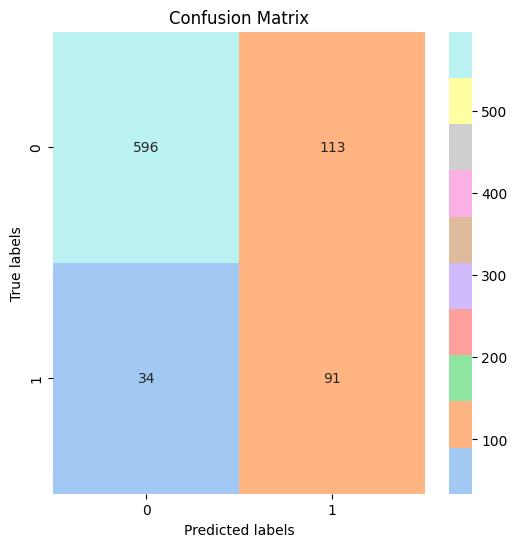

In [84]:
# For KNN model
plot_confusion_matrix(best_knn_model, new_test_df)

#### 9.4 RANDOM FORESTS

In [85]:


# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 7],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features to consider for the best split
}

# Create GridSearchCV object for Random Forest
grid_search_rf = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid,
    scoring='accuracy',  # Using accuracy as the scoring metric
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all available processors
)

# Train the model on the resampled training data (replace X_train and y_train with your data)
grid_search_rf.fit(resampled_df.drop('churn', axis=1), resampled_df['churn'])

# Get the best estimator
best_rf_model = grid_search_rf.best_estimator_

# Predict on the new_test_df using the best model
new_test_predictions_rf = best_rf_model.predict(new_test_df.drop('churn', axis=1))

# Calculate accuracy and F1-score on the new_test_df (replace y_true with true labels)
accuracy_rf = accuracy_score(new_test_df['churn'], new_test_predictions_rf)
f1_rf = f1_score(new_test_df['churn'], new_test_predictions_rf)

print(f'Accuracy on test set (Random Forest): {accuracy_rf:.4f}')
print(f'F1-score on test set (Random Forest): {f1_rf:.4f}')


Accuracy on test set (Random Forest): 0.9161
F1-score on test set (Random Forest): 0.7266


In [86]:
# Calculate accuracy, precision, recall, and F1-score on the new_test_df for Random Forest
accuracy_rf = accuracy_score(new_test_df['churn'], new_test_predictions_rf)
precision_rf = precision_score(new_test_df['churn'], new_test_predictions_rf)
recall_rf = recall_score(new_test_df['churn'], new_test_predictions_rf)
f1_rf = f1_score(new_test_df['churn'], new_test_predictions_rf)

print(f'Accuracy on test set (Random Forest): {accuracy_rf:.4f}')
print(f'Precision on test set (Random Forest): {precision_rf:.4f}')
print(f'Recall on test set (Random Forest): {recall_rf:.4f}')
print(f'F1-score on test set (Random Forest): {f1_rf:.4f}')

Accuracy on test set (Random Forest): 0.9161
Precision on test set (Random Forest): 0.7099
Recall on test set (Random Forest): 0.7440
F1-score on test set (Random Forest): 0.7266


#### 9.5 XG-BOOST - CLASSIFIER

In [87]:
# Create an XGBoost classifier

xgb_classifier = XGBClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'max_depth': [3, 6, 9],  # Maximum tree depth
    'learning_rate': [0.1, 0.01, 0.001],  # Learning rate
    'subsample': [0.7, 0.8, 0.9],  # Subsample ratio of the training instance
    'colsample_bytree': [0.7, 0.8, 0.9],  # Subsample ratio of columns when constructing each tree
}

# Create GridSearchCV object for XGBoost
grid_search_xgb = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid,
    scoring='accuracy',  # Using accuracy as the scoring metric
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all available processors
)

# Train the model on the resampled training data (replace X_train and y_train with your data)
grid_search_xgb.fit(resampled_df.drop('churn', axis=1), resampled_df['churn'])

# Get the best estimator
best_xgb_model = grid_search_xgb.best_estimator_

# Predict on the new_test_df using the best model
new_test_predictions_xgb = best_xgb_model.predict(new_test_df.drop('churn', axis=1))

# Calculate accuracy and F1-score on the new_test_df (replace y_true with true labels)
accuracy_xgb = accuracy_score(new_test_df['churn'], new_test_predictions_xgb)
f1_xgb = f1_score(new_test_df['churn'], new_test_predictions_xgb)

print(f'Accuracy on test set (XGBoost): {accuracy_xgb:.4f}')
print(f'F1-score on test set (XGBoost): {f1_xgb:.4f}')


Accuracy on test set (XGBoost): 0.9245
F1-score on test set (XGBoost): 0.7364


In [88]:
# Calculate accuracy, precision, recall, and F1-score on the new_test_df
accuracy_xgb = accuracy_score(new_test_df['churn'], new_test_predictions_xgb)
precision_xgb = precision_score(new_test_df['churn'], new_test_predictions_xgb)
recall_xgb = recall_score(new_test_df['churn'], new_test_predictions_xgb)
f1_xgb = f1_score(new_test_df['churn'], new_test_predictions_xgb)

print(f'Accuracy on test set (XGBoost): {accuracy_xgb:.4f}')
print(f'Precision on test set (XGBoost): {precision_xgb:.4f}')
print(f'Recall on test set (XGBoost): {recall_xgb:.4f}')
print(f'F1-score on test set (XGBoost): {f1_xgb:.4f}')

Accuracy on test set (XGBoost): 0.9245
Precision on test set (XGBoost): 0.7719
Recall on test set (XGBoost): 0.7040
F1-score on test set (XGBoost): 0.7364


#### 9.6 ENSEMBLING

In [89]:
# Get predictions from each base model
predictions_xgb = best_xgb_model.predict(new_test_df.drop('churn', axis=1))
predictions_rf = best_rf_model.predict(new_test_df.drop('churn', axis=1))
predictions_knn = best_knn_model.predict(new_test_df.drop('churn', axis=1))
predictions_tree = tree_pipeline.predict(new_test_df.drop('churn', axis=1))
predictions_logistic = best_model.predict(new_test_df.drop('churn', axis=1))

# Create a DataFrame with predictions and original features
predictions_df = new_test_df.drop('churn', axis=1).copy()
predictions_df['xgb_prediction'] = predictions_xgb
predictions_df['rf_prediction'] = predictions_rf
predictions_df['knn_prediction'] = predictions_knn
predictions_df['tree_prediction'] = predictions_tree
predictions_df['logistic_prediction'] = predictions_logistic

# Define the meta-learner
meta_learner = LogisticRegression(random_state=42, max_iter=1000)  # Increase max_iter

# Use predictions and original features to train the meta-learner directly
meta_learner.fit(predictions_df, new_test_df['churn'])

# Scale the predictions and original features
scaler = StandardScaler()
scaled_predictions_df = scaler.fit_transform(predictions_df)

# Use scaled predictions and original features to train the meta-learner
meta_learner.fit(scaled_predictions_df, new_test_df['churn'])

# Predict with the meta-learner using the scaled combined dataset
final_predictions_scaled = meta_learner.predict(scaled_predictions_df)

# Evaluate the meta-learner's performance with scaled data
accuracy_meta_scaled = accuracy_score(new_test_df['churn'], final_predictions_scaled)
f1_meta_scaled = f1_score(new_test_df['churn'], final_predictions_scaled)

print(f'Accuracy on test set (Meta-Learner with scaled data): {accuracy_meta_scaled:.4f}')
print(f'F1-score on test set (Meta-Learner with scaled data): {f1_meta_scaled:.4f}')


Accuracy on test set (Meta-Learner with scaled data): 0.9317
F1-score on test set (Meta-Learner with scaled data): 0.7554


In [90]:
# Calculate accuracy, precision, recall, and F1-score on the new_test_df for the meta-learner with scaled data
accuracy_meta_scaled = accuracy_score(new_test_df['churn'], final_predictions_scaled)
precision_meta_scaled = precision_score(new_test_df['churn'], final_predictions_scaled)
recall_meta_scaled = recall_score(new_test_df['churn'], final_predictions_scaled)
f1_meta_scaled = f1_score(new_test_df['churn'], final_predictions_scaled)

print(f'Accuracy on test set (Meta-Learner with scaled data): {accuracy_meta_scaled:.4f}')
print(f'Precision on test set (Meta-Learner with scaled data): {precision_meta_scaled:.4f}')
print(f'Recall on test set (Meta-Learner with scaled data): {recall_meta_scaled:.4f}')
print(f'F1-score on test set (Meta-Learner with scaled data): {f1_meta_scaled:.4f}')


Accuracy on test set (Meta-Learner with scaled data): 0.9317
Precision on test set (Meta-Learner with scaled data): 0.8148
Recall on test set (Meta-Learner with scaled data): 0.7040
F1-score on test set (Meta-Learner with scaled data): 0.7554


#### 9.7 MODELS AND THEIR PERFOMANCES

In [91]:

# Define model names
model_names = ['XGBoost', 'Random Forest', 'KNN', 'Decision Tree', 'Logistic Regression','Stacked Model ']

# Define accuracy scores
accuracy_scores = [accuracy_xgb, accuracy_rf, accuracy_knn, accuracy_tree, accuracy, accuracy_meta_scaled]  # Replace with your actual scores

# Create a DataFrame to store model names and accuracy scores
accuracy_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy Score': accuracy_scores
})

# Display the accuracy scores as a table
print(accuracy_df)


                 Model  Accuracy Score
0              XGBoost        0.924460
1        Random Forest        0.916067
2                  KNN        0.823741
3        Decision Tree        0.769784
4  Logistic Regression        0.784173
5       Stacked Model         0.931655


In [92]:
combined_scores = {
    'XGBoost': {
        'Accuracy': accuracy_xgb,
        'Precision': precision_xgb,
        'Recall': recall_xgb,
        'F1-score': f1_xgb
    },
    'Random Forest': {
        'Accuracy': accuracy_rf,
        'Precision': precision_rf,
        'Recall': recall_rf,
        'F1-score': f1_rf
    },
    'KNN': {
        'Accuracy': accuracy_knn,
        'Precision': precision_knn,
        'Recall': recall_knn,
        'F1-score': f1_knn
    },
    'Decision Tree': {
        'Accuracy': accuracy_tree,
        'Precision': precision_tree,
        'Recall': recall_tree,
        'F1-score': f1_tree
    },
    'Meta_learner_scaled_scores': {
        'Accuracy': accuracy_meta_scaled,
        'Precision': precision_meta_scaled,
        'Recall': recall_meta_scaled,
        'F1-score': f1_meta_scaled
    }
}


In [93]:

# Create lists to store model names and corresponding scores
models = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Loop through the combined_scores dictionary to extract scores for each model
for model, scores in combined_scores.items():
    models.append(model)
    accuracy_scores.append(scores['Accuracy'])
    precision_scores.append(scores['Precision'])
    recall_scores.append(scores['Recall'])
    f1_scores.append(scores['F1-score'])

# Create a DataFrame using pandas
scores_table = pd.DataFrame({
    'Model': models,
    'Accuracy Score': accuracy_scores,
    'Precision Score': precision_scores,
    'Recall Score': recall_scores,
    'F1 Score': f1_scores
})

# Display the table
print(scores_table)


                        Model  Accuracy Score  Precision Score  Recall Score  \
0                     XGBoost        0.924460         0.771930         0.704   
1               Random Forest        0.916067         0.709924         0.744   
2                         KNN        0.823741         0.446078         0.728   
3               Decision Tree        0.769784         0.356223         0.664   
4  Meta_learner_scaled_scores        0.931655         0.814815         0.704   

   F1 Score  
0  0.736402  
1  0.726562  
2  0.553191  
3  0.463687  
4  0.755365  


In [94]:
from tabulate import tabulate

# Create lists to store the table data
table_data = []
headers = ['Model', 'Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score']

# Populate the table data
for model, scores in combined_scores.items():
    table_data.append([model, scores['Accuracy'], scores['Precision'], scores['Recall'], scores['F1-score']])

# Use tabulate to create a pretty table
pretty_table = tabulate(table_data, headers=headers, tablefmt="pretty")

# Display the pretty table
print(pretty_table)


+----------------------------+--------------------+---------------------+--------------+---------------------+
|           Model            |   Accuracy Score   |   Precision Score   | Recall Score |      F1 Score       |
+----------------------------+--------------------+---------------------+--------------+---------------------+
|          XGBoost           | 0.9244604316546763 | 0.7719298245614035  |    0.704     | 0.7364016736401674  |
|       Random Forest        | 0.9160671462829736 | 0.7099236641221374  |    0.744     |      0.7265625      |
|            KNN             | 0.8237410071942446 | 0.44607843137254904 |    0.728     | 0.5531914893617021  |
|       Decision Tree        | 0.7697841726618705 | 0.3562231759656652  |    0.664     | 0.46368715083798884 |
| Meta_learner_scaled_scores | 0.9316546762589928 | 0.8148148148148148  |    0.704     | 0.7553648068669528  |
+----------------------------+--------------------+---------------------+--------------+---------------------+


##### 10 DEPLOYMENT

In [95]:

# Save the model to a file
joblib.dump(meta_learner, 'meta_learner.joblib')


['meta_learner.joblib']